# Capstone Project Submission

- Student name: Bronwen Cohn-Cort
- Student pace: self-paced
- Scheduled project review date/time: July 27, 2020
- Instructor name: Jeff Herman
- Blog post URL: https://bronwencc.github.io/pandas_dataframe_quick-start_guide_python

## Abstract
The problem was to see whether the text of abstracts authored by Nobel Prize winners that were highly cited was different from the text of abstracts from highly-cited publications authored by scientists who were listed as an author on one of the Nobel Prize winners' highly-cited publications.  The publications were from Google Scholar and the information about the Nobel Prize winners was from the Nobel Prize website.  Publications may be books as well as journal articles, and abstract text was assumed to be in English, although there is at least one suspected instance of French.

Then, the publications that had abstract text (a non-null `bib_abstract`) were put into one dataframe and the text was stripped of punctuation, tokenized and lemmatized with `nltk`.  After that, I found frequency distributions and subsequently TF-IDF (term frequency - inverse document frequency) values for each word (or name or number) in all the abstracts for each abstract.  These values were reduced to two dimensions with `sklearn`'s `TSNE` and plotted with varying color codes: author name, field of study (as related to the field in which the connected Nobel Prize was won), and whether the author of the publication was a Nobel Prize winner.

The TF-IDF values were put through Sequential models to get predictions for field of study (4 possibilities): 19% accuracy and for coauthor (Nobel Prize winner or not): 58% accuracy.  A t-test found the average TF-IDF values to not be significantly different between abstracts from a non-Prize winner's author page and those from a Prize-winner's author page.

### Import Statements

In [5]:
import pandas as pd
import numpy as np

In [6]:
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import sequence

In [3]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

In [4]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn")

In [6]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
import string

In [7]:
#use WordNet database to reduce words to roots (lemmatize)
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [4]:
import nltk
nltk.download("punkt") #download Punkt sentence tokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bronwen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
nltk.download('wordnet') #download wordnet for WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bronwen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
np.random.seed(321)

# Obtain
The bulk of obtaining is in the obtain.ipynb notebook, where it retrieved and parsed results through my modified `scholarly` package.
This section reads in the .CSV files that were created by putting together information from `newscholarly` search results for filled publication information.  It also creates new dataframe with additional informative columns consisting of those records that have abstract text (where `bib_abstract` is not null).

In [9]:
#all filled publications that were first five results for Nobel Prize winners
publidf = pd.read_csv("csvdata\publications.csv",index_col=[0])
publidf.reset_index(drop=True, inplace=True)
publidf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 23 columns):
bib_eprint         26 non-null object
bib_cites          70 non-null int64
citations_link     70 non-null object
url_scholarbib     0 non-null float64
url_add_sclib      0 non-null float64
bib_abstract       44 non-null object
bib_author_list    0 non-null float64
bib_venue          0 non-null float64
bib_year           70 non-null int64
bib_gsrank         0 non-null float64
bib_title          70 non-null object
bib_url            44 non-null object
bib_author         70 non-null object
bib_listauthors    70 non-null object
bib_journal        56 non-null object
bib_volume         60 non-null float64
bib_number         60 non-null float64
bib_publisher      64 non-null object
bib_pages          59 non-null object
source             70 non-null object
id_citations       70 non-null object
cites_per_year     70 non-null object
fileID             70 non-null object
dtypes: float64(7), int

In [10]:
#all first five filled publications for at most three authors that were first 
#listed on first five results for Nobel Prize winners
coapublidf = pd.read_csv("csvdata\copublications.csv",index_col=[0])
coapublidf.reset_index(drop=True,inplace=True)
coapublidf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 23 columns):
bib_eprint         38 non-null object
bib_cites          75 non-null int64
citations_link     75 non-null object
url_scholarbib     0 non-null float64
url_add_sclib      0 non-null float64
bib_abstract       44 non-null object
bib_author_list    0 non-null float64
bib_venue          0 non-null float64
bib_year           75 non-null int64
bib_gsrank         0 non-null float64
bib_title          75 non-null object
bib_url            44 non-null object
bib_author         75 non-null object
bib_listauthors    75 non-null object
bib_journal        64 non-null object
bib_volume         65 non-null float64
bib_number         60 non-null object
bib_publisher      61 non-null object
bib_pages          69 non-null object
source             75 non-null object
id_citations       75 non-null object
cites_per_year     75 non-null object
fileID             75 non-null object
dtypes: float64(6), int6

Create author identifier from fileID (an index number plus the last four characters of an author's name) for both dataframes listing filled publications.

In [11]:
publidf["authID"]=[ident[:-1] for ident in publidf["fileID"]]
coapublidf["authID"]=[ident[:-1] for ident in coapublidf["fileID"]]

In [12]:
#how many publications that have an abstract are there for "co-authors"
coapublidf[coapublidf.bib_abstract.isna()==False].authID.value_counts()

0Yang    5
2 Chu    4
1Bado    4
0tein    4
1anov    3
2 Zhu    3
0wman    3
1than    3
1ster    3
1Wang    3
0jima    3
0nsky    2
2iang    2
2nnan    1
1alij    1
Name: authID, dtype: int64

In [13]:
#add coauthor binary column
coapublidf["coauthor"]=1
publidf["coauthor"]=0

# Scrub
Remove author's publications known to be an incorrect search result and combine dataframes into one with all publications that have abstracts.

In [14]:
#drop rows at indices where authID is "1Bado"
coapublidf.drop(index=coapublidf[coapublidf.authID=="1Bado"].index,inplace=True)
coapublidf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 74
Data columns (total 25 columns):
bib_eprint         34 non-null object
bib_cites          70 non-null int64
citations_link     70 non-null object
url_scholarbib     0 non-null float64
url_add_sclib      0 non-null float64
bib_abstract       40 non-null object
bib_author_list    0 non-null float64
bib_venue          0 non-null float64
bib_year           70 non-null int64
bib_gsrank         0 non-null float64
bib_title          70 non-null object
bib_url            40 non-null object
bib_author         70 non-null object
bib_listauthors    70 non-null object
bib_journal        59 non-null object
bib_volume         60 non-null float64
bib_number         55 non-null object
bib_publisher      57 non-null object
bib_pages          64 non-null object
source             70 non-null object
id_citations       70 non-null object
cites_per_year     70 non-null object
fileID             70 non-null object
authID             70 no

With 44 out of 70 or 75 for each dataframe having a non-null abstract, put together dataframe of those with abstract and whether from coauthor or prize-winner list.  This is excepting 1Bado from the `coapublidf`, which I know to be information for a different author than intended.

Matching names was one of the more difficult aspects of getting the desired search results.

In [15]:
#concatenate where abstract is not null
abstractdf = pd.concat([coapublidf[coapublidf.bib_abstract.isna()==False],publidf[publidf.bib_abstract.isna()==False]])
abstractdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 69
Data columns (total 25 columns):
bib_eprint         60 non-null object
bib_cites          84 non-null int64
citations_link     84 non-null object
url_scholarbib     0 non-null float64
url_add_sclib      0 non-null float64
bib_abstract       84 non-null object
bib_author_list    0 non-null float64
bib_venue          0 non-null float64
bib_year           84 non-null int64
bib_gsrank         0 non-null float64
bib_title          84 non-null object
bib_url            84 non-null object
bib_author         84 non-null object
bib_listauthors    84 non-null object
bib_journal        70 non-null object
bib_volume         74 non-null float64
bib_number         70 non-null object
bib_publisher      75 non-null object
bib_pages          76 non-null object
source             84 non-null object
id_citations       84 non-null object
cites_per_year     84 non-null object
fileID             84 non-null object
authID             84 no

In [16]:
#reset index and not add as a column the one being replaced (drop=True)
abstractdf.reset_index(drop=True,inplace=True)
abstractdf.tail()

,bib_eprint,bib_cites,citations_link,url_scholarbib,url_add_sclib,bib_abstract,bib_author_list,bib_venue,bib_year,bib_gsrank,...,bib_volume,bib_number,bib_publisher,bib_pages,source,id_citations,cites_per_year,fileID,authID,coauthor
79,NaN,7576,/scholar?cites=9561995395788798221,NaN,NaN,We analyze a sequential decision model in whic...,NaN,NaN,1992,NaN,...,107.0,3,MIT Press,797-817,citations,HLpqZooAAAAJ:tKAzc9rXhukC,"{1994: 33, 1995: 35, 1996: 45, 1997: 59, 1998:...",9rjee0,9rjee,0
80,https://www.kellogg.northwestern.edu/research/...,3647,/scholar?cites=14356141185523981128,NaN,NaN,This paper models economic development as a pr...,NaN,NaN,1993,NaN,...,101.0,2,The University of Chicago Press,274-298,citations,HLpqZooAAAAJ:0izLItjtcgwC,"{1995: 20, 1996: 25, 1997: 25, 1998: 34, 1999:...",9rjee1,9rjee,0
81,http://brandonkendhammer.com/themes_in_global_...,3277,/scholar?cites=6324759133315472718,NaN,NaN,Winner of the 2011 Financial Times/Goldman Sac...,NaN,NaN,2011,NaN,...,NaN,NaN,Public Affairs,NaN,citations,HLpqZooAAAAJ:738O_yMBCRsC,"{2011: 57, 2012: 210, 2013: 336, 2014: 403, 20...",9rjee2,9rjee,0
82,https://pubs.aeaweb.org/doi/pdfplus/10.1257/ap...,2059,/scholar?cites=10229049581137351676,NaN,NaN,This paper reports results from the randomized...,NaN,NaN,2015,NaN,...,7.0,1,NaN,22-53,citations,HLpqZooAAAAJ:0KyAp5RtaNEC,"{2009: 8, 2010: 75, 2011: 108, 2012: 128, 2013...",9rjee3,9rjee,0
83,https://pubs.aeaweb.org/doi/pdfplus/10.1257/je...,1961,/scholar?cites=10370990907312560167,NaN,NaN,The 1990 World Development Report from the Wor...,NaN,NaN,2007,NaN,...,21.0,1,NaN,141-168,citations,HLpqZooAAAAJ:ipzZ9siozwsC,"{2006: 5, 2007: 27, 2008: 71, 2009: 66, 2010: ...",9rjee4,9rjee,0


In [17]:
#save this dataframe
abstractdf.to_csv("csvdata\pubs_with_abstracts.csv")

In [4]:
abstractdf = pd.read_csv("csvdata\pubs_with_abstracts.csv", index_col=[0])
abstractdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 25 columns):
bib_eprint         60 non-null object
bib_cites          84 non-null int64
citations_link     84 non-null object
url_scholarbib     0 non-null float64
url_add_sclib      0 non-null float64
bib_abstract       84 non-null object
bib_author_list    0 non-null float64
bib_venue          0 non-null float64
bib_year           84 non-null int64
bib_gsrank         0 non-null float64
bib_title          84 non-null object
bib_url            84 non-null object
bib_author         84 non-null object
bib_listauthors    84 non-null object
bib_journal        70 non-null object
bib_volume         74 non-null float64
bib_number         70 non-null object
bib_publisher      75 non-null object
bib_pages          76 non-null object
source             84 non-null object
id_citations       84 non-null object
cites_per_year     84 non-null object
fileID             84 non-null object
authID             84 no

Add field from Nobel Prize winner information to authorinfo.csv.

In [9]:
authdf = pd.read_csv("csvdata/authorinfo.csv",index_col=[0])
authdf.reset_index(drop=True, inplace=True)
authdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 17 columns):
affiliation       31 non-null object
id                31 non-null object
name              31 non-null object
citedby           31 non-null int64
citedby5y         29 non-null float64
cites_per_year    29 non-null object
coauthors         29 non-null object
email             29 non-null object
hindex            29 non-null float64
hindex5y          29 non-null float64
i10index          29 non-null float64
i10index5y        29 non-null float64
interests         31 non-null object
url_picture       31 non-null object
filled            31 non-null bool
fileID            31 non-null object
coauthor          31 non-null int64
dtypes: bool(1), float64(5), int64(2), object(9)
memory usage: 4.0+ KB


In [10]:
#checking all fileID's are unique to each record
sum(authdf.fileID.value_counts())

31

In [10]:
#get sciences Nobel Prize winner information from 2010-2019
sciwindf = pd.read_csv("files/science10years.csv",index_col=[0])
sciwindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 1 to 168
Data columns (total 5 columns):
name1         95 non-null object
text1         95 non-null object
year          95 non-null int64
field         95 non-null object
additional    95 non-null object
dtypes: int64(1), object(4)
memory usage: 4.5+ KB


In [121]:
sciwindf["thor"]=[name[-4:] for name in sciwindf.name1] #last four characters of authorname

In [122]:
#be sure last four characters are unique
sum(sciwindf.thor.value_counts())

95

In [11]:
#create new empty column for winning area in authdf
authdf["area"]=np.nan

In [180]:
#add field if sciwindf.thor matches last 4 characters from fileID from authdf
for idx, nameid in zip(authdf.index,authdf.fileID):
    last4 = nameid[-4:]
    winarea = sciwindf[sciwindf.thor==last4].field
    area = None
    try:
        for i in winarea:
            area = i
    except:
        continue
        
    authdf.iloc[idx,-1]=area #last column is "area"

In [181]:
#it should be where area is missing, is also not Nobel Prize winners
authdf.head()

,affiliation,id,name,citedby,citedby5y,cites_per_year,coauthors,email,hindex,hindex5y,i10index,i10index5y,interests,url_picture,filled,fileID,coauthor,area
0,"University of Chicago, Booth School of Business",Tvzd5GgAAAAJ,Richard Thaler,151057,61520.0,"{1991: 412, 1992: 487, 1993: 505, 1994: 679, 1...",[],@chicagobooth.edu,98.0,80.0,183.0,145.0,['Behavioral Economics'],https://scholar.google.com/citations?view_op=m...,True,0aler,0,economics
1,Bell Labs retired,3QEKOmMAAAAJ,Arthur Ashkin,41204,9838.0,"{1981: 138, 1982: 143, 1983: 123, 1984: 196, 1...",[],NaN,62.0,35.0,117.0,53.0,"['Laser trapping', 'solar power']",https://scholar.google.com/citations?view_op=m...,True,0hkin,0,physics
2,"Norman Rostoker Chair Professor, UC Irvine",qwN3bpIAAAAJ,Toshiki Tajima,27945,7924.0,"{1982: 80, 1983: 105, 1984: 99, 1985: 191, 198...",[],@uci.edu,75.0,37.0,317.0,132.0,"['plasma physics', 'accelerators', 'lasers']",https://scholar.google.com/citations?view_op=m...,True,0jima,1,None
3,University of Michigan,pGGjfS8AAAAJ,Daniel J. Klionsky,90326,43675.0,"{1997: 301, 1998: 326, 1999: 328, 2000: 533, 2...",[{'affiliation': 'Department of Biomedical Sci...,@umich.edu,129.0,85.0,353.0,297.0,['Autophagy'],https://scholar.google.com/citations?view_op=m...,True,0nsky,1,None
4,"Professor of Economics, Booth School of Busine...",zGJKZpkAAAAJ,Marianne Bertrand,44683,NaN,NaN,NaN,@chicagobooth.edu,NaN,NaN,NaN,NaN,['Marianne Bertrand'],https://scholar.google.com/citations?view_op=m...,False,0rand,1,None


In [184]:
#save new file of author information with winning areas
authdf.to_csv("files/authors.csv")

In [16]:
#create column of last four characters of an author name from fileID to compare with abstractdf
authdf["name4"] = [fileid[-4:] for fileid in authdf["fileID"]]

Use information from `authdf` to fill in `abstractdf` with Nobel Prize winning field for that author or coauthor.

In [17]:
#initialize column to be null
abstractdf["area"]=None

In [18]:
#if an author in bib_listauthors matches an authdf.name4 and area is not NaN
for idx, authors in zip(abstractdf.index,abstractdf.bib_listauthors):
    authlist = authors.strip("[]").split(", ")#expecting string with appearance of a list: ['Name H Itisi', 'I M Here']
    area = None
    hasfield=False
    for auth in authlist:
        authname = auth.strip("'")#remove trailing or leading apostrophes
        abslast4 = authname[-4:] #find whether last four characters match a name in authdf and add that field
        winarea = authdf[authdf.name4==abslast4].area #find the winning subject area for that match
        try:
            for i in winarea: #winarea is a Series with an index, so iterating gives the desired value
                area = i
            hasfield = True
        except:
            continue
        if hasfield:#the first author listed in bib_listauthors that matches an author in authdf and has a useful result
            abstractdf.iloc[idx,-1]=area #last column is "area", that record will be classified in that area
            break #and leave the loop since it found an area for this list of authors for this record
        else:
            continue

In [21]:
#create list with one dataframe for each authID and concatenate back together
#after filling with nearby values in area
concatlist = []
for authorID in abstractdf.authID.value_counts().index: #set of authID values
    tempdf = abstractdf[abstractdf.authID==authorID].copy() #separate out each dataframe by authID
    tempdf.area.fillna(method="ffill",inplace=True) #fill forwards
    tempdf.area.fillna(method="bfill",inplace=True) #fill backwards
    concatlist.append(tempdf)
newabsdf = pd.concat(concatlist)

In [22]:
newabsdf[newabsdf.coauthor==0].tail()

,bib_eprint,bib_cites,citations_link,url_scholarbib,url_add_sclib,bib_abstract,bib_author_list,bib_venue,bib_year,bib_gsrank,...,bib_number,bib_publisher,bib_pages,source,id_citations,cites_per_year,fileID,authID,coauthor,area
72,https://rupress.org/jem/article-pdf/182/2/459/...,1918,/scholar?cites=6876382103574609531,NaN,NaN,The importance of the B7/CD28/CTLA-4 molecules...,NaN,NaN,1995,NaN,...,2,NaN,459-465,citations,Vq6NVkAAAAAJ:UeHWp8X0CEIC,"{1995: 6, 1996: 41, 1997: 52, 1998: 82, 1999: ...",6ison3,6ison,0,None
73,NaN,1837,/scholar?cites=5037358054144997456,NaN,NaN,OCCUPANCY of the T-cell antigen receptor is in...,NaN,NaN,1992,NaN,...,6370,Nature Publishing Group,607-609,citations,Vq6NVkAAAAAJ:d1gkVwhDpl0C,"{1992: 21, 1993: 79, 1994: 110, 1995: 100, 199...",6ison4,6ison,0,None
44,NaN,3362,/scholar?cites=15657353520048317916,NaN,NaN,The light-driven proton pump-bacteriorhodopsin...,NaN,NaN,1990,NaN,...,4,Academic Press,899-929,citations,Dg6IGLQAAAAJ:1yQoGdGgb4wC,"{1990: 22, 1991: 162, 1992: 223, 1993: 204, 19...",0rson0,0rson,0,chemistry
45,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,1645,/scholar?cites=11193056054889213690,NaN,NaN,G-protein-coupled receptors have a major role ...,NaN,NaN,2008,NaN,...,7203,Nature Publishing Group,486-491,citations,Dg6IGLQAAAAJ:OU6Ihb5iCvQC,"{2008: 32, 2009: 183, 2010: 228, 2011: 263, 20...",0rson2,0rson,0,chemistry
70,NaN,3207,/scholar?cites=16355212970030274248,NaN,NaN,NEW ways of making antibodies have recently be...,NaN,NaN,1990,NaN,...,6301,Nature Publishing Group,552-554,citations,QQOy6PIAAAAJ:u5HHmVD_uO8C,"{1991: 29, 1992: 54, 1993: 62, 1994: 70, 1995:...",5nter0,5nter,0,None


In [23]:
#some values for area are missing from Nobel Prize winners (where authdf.coauthor is 0)
#add area if last four characters from newabsdf.authID matches fileID from authdf
for idx, nameid in zip(newabsdf.index,newabsdf.authID):
    if newabsdf.iloc[idx,-2]==0: #if the coauthor column is 0, the record is for a Nobel winner
        last4 = nameid[-4:]
        winarea = authdf[authdf.name4==last4].area #get area value from author info dataframe
        absarea = None
        hasarea = False
        try:
            for i in winarea:
                absarea = i
        except:
            continue #go on to next record
    
        if hasarea and newabsdf.iloc[idx,-1]==None:
            newabsdf.iloc[idx,-1]=absarea #"area" was last column added
            # the value at the corresponding index for this authID is set to the area from authdf
        continue

In [24]:
newabsdf.area.value_counts()

economics    20
physics      15
medicine     11
chemistry     6
Name: area, dtype: int64

This method of using the last four characters did not work completely well and left some records in `area` empty, so I manually searched for who were coauthors of Nobel Prize winners in my rough draft notebook and then looked up in `sciwindf` in which field they won.

In [302]:
#example lookup for gham having alij as a coauthor
sciwindf[sciwindf.thor=="gham"]

,name1,text1,year,field,additional,thor
5,M. Stanley Whittingham,"John B. Goodenough, M. Stanley Whittingham and...",2019,chemistry,"['a>, <a href=""https:', 'a> and <a href=""https...",gham


In [303]:
#since gham won in chemistry, alij's publications will also be classified as such
prefindx = newabsdf[newabsdf.authID=="1alij"].index
newabsdf.loc[prefindx,"area"]="chemistry"

I saved the resulting `newabsdf`, after manually adding the rest of the values for `area` as "abstractsinfo.csv", which can be read in below as `infodf`.

In [24]:
infodf = pd.read_csv("csvdata/abstractsinfo.csv", index_col=[0])
infodf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 27 columns):
index              84 non-null int64
bib_eprint         60 non-null object
bib_cites          84 non-null int64
citations_link     84 non-null object
url_scholarbib     0 non-null float64
url_add_sclib      0 non-null float64
bib_abstract       84 non-null object
bib_author_list    0 non-null float64
bib_venue          0 non-null float64
bib_year           84 non-null int64
bib_gsrank         0 non-null float64
bib_title          84 non-null object
bib_url            84 non-null object
bib_author         84 non-null object
bib_listauthors    84 non-null object
bib_journal        70 non-null object
bib_volume         74 non-null float64
bib_number         70 non-null object
bib_publisher      75 non-null object
bib_pages          76 non-null object
source             84 non-null object
id_citations       84 non-null object
cites_per_year     84 non-null object
fileID             84 non

In [29]:
#sorting by index column, then dropping it
infodf.set_index(infodf["index"], inplace=True)
infodf.sort_index(inplace=True)
infodf.drop(columns=["index"],inplace=True)
infodf.tail()

,bib_eprint,bib_cites,citations_link,url_scholarbib,url_add_sclib,bib_abstract,bib_author_list,bib_venue,bib_year,bib_gsrank,...,bib_number,bib_publisher,bib_pages,source,id_citations,cites_per_year,fileID,authID,coauthor,area
index,,,,,,,,,,,,,,,,,,,,,
79,NaN,7576,/scholar?cites=9561995395788798221,NaN,NaN,We analyze a sequential decision model in whic...,NaN,NaN,1992,NaN,...,3.0,MIT Press,797-817,citations,HLpqZooAAAAJ:tKAzc9rXhukC,"{1994: 33, 1995: 35, 1996: 45, 1997: 59, 1998:...",9rjee0,9rjee,0,economics
80,https://www.kellogg.northwestern.edu/research/...,3647,/scholar?cites=14356141185523981128,NaN,NaN,This paper models economic development as a pr...,NaN,NaN,1993,NaN,...,2.0,The University of Chicago Press,274-298,citations,HLpqZooAAAAJ:0izLItjtcgwC,"{1995: 20, 1996: 25, 1997: 25, 1998: 34, 1999:...",9rjee1,9rjee,0,economics
81,http://brandonkendhammer.com/themes_in_global_...,3277,/scholar?cites=6324759133315472718,NaN,NaN,Winner of the 2011 Financial Times/Goldman Sac...,NaN,NaN,2011,NaN,...,NaN,Public Affairs,NaN,citations,HLpqZooAAAAJ:738O_yMBCRsC,"{2011: 57, 2012: 210, 2013: 336, 2014: 403, 20...",9rjee2,9rjee,0,economics
82,https://pubs.aeaweb.org/doi/pdfplus/10.1257/ap...,2059,/scholar?cites=10229049581137351676,NaN,NaN,This paper reports results from the randomized...,NaN,NaN,2015,NaN,...,1.0,NaN,22-53,citations,HLpqZooAAAAJ:0KyAp5RtaNEC,"{2009: 8, 2010: 75, 2011: 108, 2012: 128, 2013...",9rjee3,9rjee,0,economics
83,https://pubs.aeaweb.org/doi/pdfplus/10.1257/je...,1961,/scholar?cites=10370990907312560167,NaN,NaN,The 1990 World Development Report from the Wor...,NaN,NaN,2007,NaN,...,1.0,NaN,141-168,citations,HLpqZooAAAAJ:ipzZ9siozwsC,"{2006: 5, 2007: 27, 2008: 71, 2009: 66, 2010: ...",9rjee4,9rjee,0,economics


In [31]:
sum(infodf.area.isna())

0

In [30]:
infodf.area.value_counts()

economics    23
physics      22
chemistry    20
medicine     19
Name: area, dtype: int64

### Possible duplicates

In [63]:
infodf[infodf.citations_link=="/scholar?cites=10229049581137351676"]

,bib_eprint,bib_cites,citations_link,url_scholarbib,url_add_sclib,bib_abstract,bib_author_list,bib_venue,bib_year,bib_gsrank,...,bib_number,bib_publisher,bib_pages,source,id_citations,cites_per_year,fileID,authID,coauthor,area
index,,,,,,,,,,,,,,,,,,,,,
39,https://pubs.aeaweb.org/doi/pdfplus/10.1257/ap...,2076,/scholar?cites=10229049581137351676,NaN,NaN,This paper reports results from the randomized...,NaN,NaN,2015,NaN,...,1,NaN,22-53,citations,Uiujt8gAAAAJ:u5HHmVD_uO8C,"{2009: 8, 2010: 75, 2011: 108, 2012: 129, 2013...",2nnan0,2nnan,1,economics
49,https://pubs.aeaweb.org/doi/pdfplus/10.1257/ap...,2059,/scholar?cites=10229049581137351676,NaN,NaN,This paper reports results from the randomized...,NaN,NaN,2015,NaN,...,1.0,NaN,22-53,citations,yhDMl8AAAAAJ:W7OEmFMy1HYC,"{2009: 8, 2010: 75, 2011: 108, 2012: 128, 2013...",10uflo3,10uflo,0,economics
82,https://pubs.aeaweb.org/doi/pdfplus/10.1257/ap...,2059,/scholar?cites=10229049581137351676,NaN,NaN,This paper reports results from the randomized...,NaN,NaN,2015,NaN,...,1.0,NaN,22-53,citations,HLpqZooAAAAJ:0KyAp5RtaNEC,"{2009: 8, 2010: 75, 2011: 108, 2012: 128, 2013...",9rjee3,9rjee,0,economics


Before truly beginning analysis, some publications may have been added more than once so I will remove those with enough similar information with `drop duplicates`; keeping one of each publication.

In [65]:
infodf.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 83
Data columns (total 26 columns):
bib_eprint         60 non-null object
bib_cites          84 non-null int64
citations_link     84 non-null object
url_scholarbib     0 non-null float64
url_add_sclib      0 non-null float64
bib_abstract       84 non-null object
bib_author_list    0 non-null float64
bib_venue          0 non-null float64
bib_year           84 non-null int64
bib_gsrank         0 non-null float64
bib_title          84 non-null object
bib_url            84 non-null object
bib_author         84 non-null object
bib_listauthors    84 non-null object
bib_journal        70 non-null object
bib_volume         74 non-null float64
bib_number         70 non-null object
bib_publisher      75 non-null object
bib_pages          76 non-null object
source             84 non-null object
id_citations       84 non-null object
cites_per_year     84 non-null object
fileID             84 non-null object
authID             84 no

In [69]:
#there are no records that match completely, so I will specify where the abstract, eprint and citations_link are the same
finaldf = infodf.drop_duplicates(subset=["bib_abstract","citations_link","bib_eprint"])
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 83
Data columns (total 26 columns):
bib_eprint         52 non-null object
bib_cites          76 non-null int64
citations_link     76 non-null object
url_scholarbib     0 non-null float64
url_add_sclib      0 non-null float64
bib_abstract       76 non-null object
bib_author_list    0 non-null float64
bib_venue          0 non-null float64
bib_year           76 non-null int64
bib_gsrank         0 non-null float64
bib_title          76 non-null object
bib_url            76 non-null object
bib_author         76 non-null object
bib_listauthors    76 non-null object
bib_journal        64 non-null object
bib_volume         67 non-null float64
bib_number         63 non-null object
bib_publisher      69 non-null object
bib_pages          69 non-null object
source             76 non-null object
id_citations       76 non-null object
cites_per_year     76 non-null object
fileID             76 non-null object
authID             76 no

In [70]:
#reset index and save as abstracts76
finaldf.reset_index(drop=True,inplace=True)
finaldf.to_csv("csvdata/abstracts76.csv")
finaldf.tail()

,bib_eprint,bib_cites,citations_link,url_scholarbib,url_add_sclib,bib_abstract,bib_author_list,bib_venue,bib_year,bib_gsrank,...,bib_number,bib_publisher,bib_pages,source,id_citations,cites_per_year,fileID,authID,coauthor,area
71,https://www.pnas.org/content/pnas/92/12/5510.f...,6226,/scholar?cites=10213045301581163199,NaN,NaN,Hypoxia-inducible factor 1 (HIF-1) is found in...,NaN,NaN,1995,NaN,...,12.0,National Academy of Sciences,5510-5514,citations,fX-_IToAAAAJ:u-x6o8ySG0sC,"{1996: 46, 1997: 98, 1998: 100, 1999: 97, 2000...",8enza2,8enza,0,medicine
72,https://cancerres.aacrjournals.org/content/can...,3204,/scholar?cites=2577141153893460087,NaN,NaN,"Neovascularization and increased glycolysis, t...",NaN,NaN,1999,NaN,...,22.0,American Association for Cancer Research,5830-5835,citations,fX-_IToAAAAJ:9yKSN-GCB0IC,"{2000: 30, 2001: 65, 2002: 93, 2003: 100, 2004...",8enza4,8enza,0,medicine
73,NaN,7576,/scholar?cites=9561995395788798221,NaN,NaN,We analyze a sequential decision model in whic...,NaN,NaN,1992,NaN,...,3.0,MIT Press,797-817,citations,HLpqZooAAAAJ:tKAzc9rXhukC,"{1994: 33, 1995: 35, 1996: 45, 1997: 59, 1998:...",9rjee0,9rjee,0,economics
74,https://www.kellogg.northwestern.edu/research/...,3647,/scholar?cites=14356141185523981128,NaN,NaN,This paper models economic development as a pr...,NaN,NaN,1993,NaN,...,2.0,The University of Chicago Press,274-298,citations,HLpqZooAAAAJ:0izLItjtcgwC,"{1995: 20, 1996: 25, 1997: 25, 1998: 34, 1999:...",9rjee1,9rjee,0,economics
75,https://pubs.aeaweb.org/doi/pdfplus/10.1257/je...,1961,/scholar?cites=10370990907312560167,NaN,NaN,The 1990 World Development Report from the Wor...,NaN,NaN,2007,NaN,...,1.0,NaN,141-168,citations,HLpqZooAAAAJ:ipzZ9siozwsC,"{2006: 5, 2007: 27, 2008: 71, 2009: 66, 2010: ...",9rjee4,9rjee,0,economics


# Explore
With dataframe of records that have abstracts, analyze abstract text for each with `nltk` and get TF-IDF values for each.

In [73]:
def cleantokens(textstring):
    '''
    A function to remove punctuation, various other symbol characters, newlines, and English stopwords from textstring.
    It returns words or sequences of numbers (and/or letters) from textstring as tokens using nltk.word_tokenize.
    
    Args
        textstring (str) : A string of text, assumed to be in English, with words separated by spaces.
    
    Returns
        cleantokens (list) : lowercase words (including acronyms) from textstring not in stopwords.words("english")
    '''
    stopwordspunct = stopwords.words("english")
    stopwordspunct += list(string.punctuation)
    stopwordspunct += ["…","\+","''","‘","’","“","”","—","\*","à"] #other punctuation that was unaccounted for
    for symbol in "\+,.?!;-\\:\∼\~'\n\'…‘’“”—\*":#replace punctuation with an empty string, including ~ and ∼
        textstring = textstring.replace(symbol, '').lower() #put into lowercase
    tokenized = word_tokenize(textstring)
    #alternately:
    cleanedtokens = [word.lower() for word in tokenized if word not in stopwordspunct]
    return cleanedtokens

The next code blocks get a list of lists of all words in all abstracts.

In [74]:
abstractext = [abstract for abstract in finaldf.bib_abstract]#each entry in bib_abstract is one string
tokenslists = []
abstractlist = []
for each in abstractext: #a list of Strings
    tokens = cleantokens(each) #get tokens
    lemmlist = []
    for token in tokens:
        lemtoken = lemmatizer.lemmatize(token)
        lemmlist.append(lemtoken) #lemmatize each token, add as item to list
        abstractlist.append(lemtoken) #add to one big list with no distinction between abstracts
    tokenslists.append(lemmlist) #each list of lemmatized tokens is an item in the list

In [75]:
#freqdist for all words in all abstracts
absfreq = FreqDist(abstractlist)
absfreq.most_common(10)

[('cell', 39),
 ('laser', 32),
 ('pulse', 31),
 ('gene', 26),
 ('also', 24),
 ('1', 23),
 ('process', 21),
 ('new', 20),
 ('energy', 19),
 ('hif1', 19)]

In [76]:
len(absfreq)

2500

The most common is "cell" although there are 2500 unique words, numbers (and likely, names as well) in total for all abstract text.

Now, I will get the TF-IDF values for each word for each abstract text.

In [78]:
#get frequency dictionaries for each list of words
freqlist = []
for tokenslist in tokenslists:
    freqdistr = FreqDist(tokenslist)
    freqlist.append(freqdistr)

The below are based on the TF-IDF lab comparing song lyrics https://github.com/learn-co-curriculum/ds-word-vectorization-lab/ that get term frequency - inverse term frequency.

In [79]:
#get term frequency:
def proportional_freq(freqdict):
    '''
    If given a frequency dictionary, would return a new dictionary with the same keys and the frequencies relative to the
    total sum of the frequencies (total number of times all keys were counted): a key's given value / sum of all values.
    
    Args
        freqdict (dict or similar) : has words as keys and their frequencies in the text as the values
        
    Returns
        propor (dict) : same keys as freqdict, values are freqdict's value divided by the total sum of freqdict's values
    '''
    totalcount = sum(freqdict.values()) #the total number of words, summing up all the frequency counts
    
    propor=dict()
    
    for item, freq in freqdict.items(): #iterate over each item-frequency pair
        propor[item] = freq/totalcount
    
    return propor

In [80]:
#find inverse document frequency given a list of frequency dictionaries
def calc_inverse_freq(freqdlist):
    '''
    Takes in a list of frequency dictionaries and finds the inverse document frequency for every key. Returns one dict
    containing all of the set of keys across all freqdlist's dictionaries with the inverse document frequency as the values
    
    Args
        freqdlist (list) : list of frequency dictionaries that are part of the same corpus
    
    Returns
        inversedict (dict) : the keys are from the dictionaries in freqdlist's keys and the values are log-transformed
                            inverse document frequency (the number of dictionaries / how many dicts the key appears in)
    '''
    listlen = len(freqdlist)
    
    totfreqd = dict()
    for freqd in freqdlist: #create frequency dictionary with every key across all dictionaries in freqdlist
        for key in freqd.keys():
            totfreqd[key]=totfreqd.get(key,0)+1 #if key does not exist already, creates it with value of 1
            #totfreqd contains how many times a word appears at least once in a freqd from freqdlist (the number of 
            #documents a word appears in)
    
    inversedict=dict()
    for word, freq in totfreqd.items():#for every token-frequency pair in totfreqd
        #inversedict contains log of (the total number of dictionaries (documents) / how many documents word appears in)
        inversedict[word] = np.log(listlen/float(freq)) #the log of this quotient (to divide well, needs float type)
        # (so the difference between 10 and 20 is bigger than between 100 and 120)
    return inversedict

In [81]:
#for term frequency, I used FreqDist object from nltk
def termf_invdf(listofdicts):
    '''
    Finds term frequency-inverse document frequency for every key in each given frequency dictionary in listofdicts and
    returns the values in tfidf_dictslist list of dictionaries, each having every key from across listofdicts.
    
    Args
        listofdicts (list) : list of frequency dictionaries
    
    Returns
        tfidf_dictslist (list) : list of dictionaries, each with keys of all of the keys across listofdicts' dictionaries
                                and the values are term frequency * inverse document frequency derived from same
    '''
    idfdict = calc_inverse_freq(listofdicts)
    newdict = {i:0 for i in list(idfdict.keys())} #all the words from all dictionaries in the list
    
    tfidf_dictslist=[]

    for eachdict in listofdicts:
        tfidf_dict = newdict.copy() #dictionary with keys as all the tokens in the corpus and all have values of 0
        profreq = proportional_freq(eachdict) #gets term frequency
        for word in profreq.keys():
            tfidf_dict[word] = profreq[word]*idfdict[word] #multiply proportional frequency by inverse frequency
        tfidf_dictslist.append(tfidf_dict) #each dictionary lists every word in the corpus
        #if a word is not in eachdict, it has a value of 0 in its corresponding tfidf_dict
        
    return tfidf_dictslist

Use frequency distributions FreqDist objects (similar to dictionaries) to get list of dictionaries of TF-IDF values for each abstract.

In [82]:
tfidflist = termf_invdf(freqlist)
#put all TF-IDF values into dataframe format
tfidframe = pd.DataFrame(tfidflist)

In [98]:
#tfidflist is a list of dictionaries where each dictionary is every word's tfidf value for an abstract
tfidflist[41]["cell"]

0.09558638273809245

As a dataframe, each record is for one asbtract.

In [101]:
tfidframe.head()

,00001,005,012,019,04,05,075,0982,1,10,...,zero,zerodispersion,zettawatt,zone,zt,µm,å,αhelices,β,μm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.101559,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.029523,...,0.0,0.0,0.050357,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065471,0.057704,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019205,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#interesting note: there are two different strings for micrometers
"µm"=="μm"

False

In [102]:
tfidframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Columns: 2500 entries, 00001 to μm
dtypes: float64(2500)
memory usage: 1.4 MB


In [87]:
#save TF-IDF values to .CSV file
tfidframe.to_csv("csvdata/tfidfvalues.csv")

In [84]:
tfidframe.describe()

,00001,005,012,019,04,05,075,0982,1,10,...,zero,zerodispersion,zettawatt,zone,zt,µm,å,αhelices,β,μm
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,...,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.000619,0.000640,0.001351,0.000982,0.000966,0.000966,0.001899,0.000587,0.005815,0.004591,...,0.001540,0.001965,0.000663,0.000640,0.001266,0.001212,0.000655,0.000655,0.002620,0.002499
std,0.005400,0.005582,0.008479,0.008565,0.008420,0.008420,0.016559,0.005121,0.012142,0.017626,...,0.013426,0.017130,0.005776,0.005582,0.011039,0.010570,0.005710,0.005710,0.022840,0.015891
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.047073,0.048660,0.062717,0.074668,0.073402,0.073402,0.144358,0.044647,0.065471,0.101559,...,0.117047,0.149336,0.050357,0.048660,0.096239,0.092143,0.049779,0.049779,0.199114,0.121253


In [112]:
#quick calculation for average tokens per abstract
totalwords=0
for i in tokenslists: #list of lists of tokens
    totalwords+=len(i) #how many tokens in each abstract = length of list
totalwords/finaldf.shape[0] #with number of rows in finaldf

70.17105263157895

Most values are zero, likely indicating that most tokens are not in most abstracts, as there are 70 tokens on average in each abstract.  Of the tokens shown by `.describe()` at a glance, β is the most unique; with a maximum TF-IDF value of 0.2 (closest to 1).

In [85]:
statsframe = tfidframe.describe()
statsframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, count to max
Columns: 2500 entries, 00001 to μm
dtypes: float64(2500)
memory usage: 156.3+ KB


In [86]:
#finding the highest values for which tokens
statsframeT = statsframe.T
statsframeT[statsframeT["max"]>.37]

,count,mean,std,min,25%,50%,75%,max
decision,76.0,0.008881,0.066841,0.0,0.0,0.0,0.0,0.580124
disulfide,76.0,0.004884,0.042580,0.0,0.0,0.0,0.0,0.371206
guideline,76.0,0.006331,0.055197,0.0,0.0,0.0,0.0,0.481193
journal,76.0,0.006331,0.055197,0.0,0.0,0.0,0.0,0.481193
openness,76.0,0.006331,0.055197,0.0,0.0,0.0,0.0,0.481193
promote,76.0,0.006331,0.055197,0.0,0.0,0.0,0.0,0.481193
reproducibility,76.0,0.006331,0.055197,0.0,0.0,0.0,0.0,0.481193
social,76.0,0.007200,0.059650,0.0,0.0,0.0,0.0,0.519655
titanium,76.0,0.004884,0.042580,0.0,0.0,0.0,0.0,0.371206
transparency,76.0,0.006331,0.055197,0.0,0.0,0.0,0.0,0.481193


There are ten tokens with the TF-IDF values in the dataset that are above 0.37.  The highest, or most unique, is "decision" at 0.58 although six have the same `max` value of 0.481193.

### Plot TF-IDF values
Use t-SNE (t-Stochastic Neighbors Embedding) from sci-kit learn to graph the values.

In [114]:
#list of lists of values from the list of tf-idf dictionaries
tfidfvalues = []
for tfidfdict in tfidflist:
    tfidfvalues.append(list(tfidfdict.values())) #convert values of each to list

In [115]:
def graphdims(transformed, dims=3):
    '''
    Transpose a list of lists or similar iterable from one N-length list of dims-length lists -> one list of dims 
    number of N-length lists.  It's like switching a matrix coordinate from (i, j) to be (j, i) except using a list of lists
    
    Args
        transformed (list or arraylike) : an arraylike of an arraylike of dimension dims x N (dims lists each of size N)
        dims (int) : defaults to 3. The desired dimension of the returned list of lists
    
    Returns
        coordlist (list) : a list of lists of dimension N x dims (N lists each of size dims)
    '''
    coordlist = [[] for i in range(0,dims)] #list of lists
    for coord in transformed:
        for j in range(0,dims):
            coordlist[j].append(coord[j])
    return coordlist

In [116]:
#reduce to two dimensions to graph on x-y axes
dim2TSNE = TSNE(n_components=2) #using sklearn
dim2data = dim2TSNE.fit_transform(tfidfvalues)
dim2abstr = graphdims(dim2data,2) #kind of transpose list of lists

In [117]:
#check graphdims changed shape as expected
print(dim2data.shape, len(dim2abstr), len(dim2abstr[0]))

(76, 2) 2 76


In [118]:
#add coordinates as columns to finaldf
finaldf["xcoord"] = dim2abstr[0]
finaldf["ycoord"] = dim2abstr[1]

In [99]:
finaldf.describe()

,bib_cites,url_scholarbib,url_add_sclib,bib_author_list,bib_venue,bib_year,bib_gsrank,bib_volume,coauthor,xcoord,ycoord
count,84.000000,0.0,0.0,0.0,0.0,84.000000,0.0,74.000000,84.000000,84.000000,84.000000
mean,2621.285714,NaN,NaN,NaN,NaN,1999.095238,NaN,117.513514,0.476190,-1.990760,-1.018079
std,2671.687381,NaN,NaN,NaN,NaN,11.264208,NaN,135.836348,0.502432,0.047559,0.128755
min,115.000000,NaN,NaN,NaN,NaN,1970.000000,NaN,1.000000,0.000000,-2.071116,-2.120370
25%,816.000000,NaN,NaN,NaN,NaN,1992.000000,NaN,16.000000,0.000000,-2.025946,-1.048383
50%,1859.500000,NaN,NaN,NaN,NaN,2001.000000,NaN,74.500000,0.000000,-1.998901,-0.992442
75%,3277.000000,NaN,NaN,NaN,NaN,2007.250000,NaN,122.000000,1.000000,-1.948087,-0.977833
max,16449.000000,NaN,NaN,NaN,NaN,2016.000000,NaN,489.000000,1.000000,-1.911947,-0.907310


In [119]:
#save with coordinates
finaldf.to_csv("csvdata/abs76coords.csv")

In [9]:
finaldf = pd.read_csv("csvdata/abs76coords.csv", index_col=[0])

Match individual colors to each `authID` for graph.

In [122]:
authidlist = finaldf.authID
authidset = set(authidlist)

In [123]:
len(authidset)

26

In [124]:
#create list of 26 color names to be for each authID
colors = ["darkgrey","dimgray","brown","red","tomato","sienna",
          "chocolate","darkorange","tan","gold","darkkhaki","y",
         "yellowgreen","green","c","royalblue","slateblue","navy",
         "blue","mediumpurple","violet","fuchsia","deeppink",
         "lawngreen","cyan","darkgoldenrod"]

In [125]:
len(colors)==len(authidset)

True

In [126]:
#create dictionary for color names
colordict = dict()
for authid,color in zip(authidset,colors):
    colordict[authid]=color

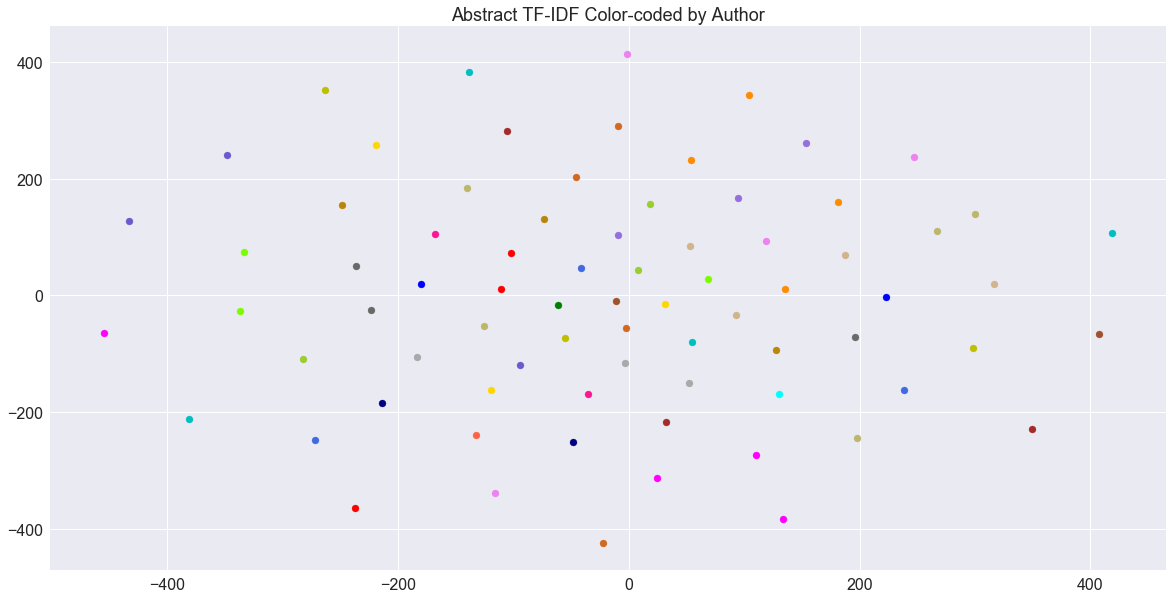

In [130]:
#graph with the authID's for the corresponding abstracts
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
for xcoord, ycoord, authid in zip(dim2abstr[0], dim2abstr[1], authidlist):
    colr = colordict[authid]
    ax.scatter(xcoord, ycoord, c=colr, label=authid)

pts = 18 #font pt size

plt.rc('axes', titlesize=pts, labelsize=pts)     # font size of the axes titles and labels
plt.rc('xtick', labelsize=pts-2)    # font size of the tick labels
plt.rc('ytick', labelsize=pts-2)    # font size of the tick labels
plt.rc('figure', titlesize=30) #title font size, slightly larger than the other text

plt.title('Abstract TF-IDF Color-coded by Author')
#plt.savefig("images/dots-by-author.png")

#ax.legend(ncol=8) #with the legend, it was hard to see which was a datapoint and which might be in the key
plt.show()

Match four colors for Nobel Prize field to graph and look for clusters.

In [131]:
fourcolors = ["darkgreen","blue","goldenrod","magenta"]

In [132]:
fieldset = ["physics","chemistry","economics","medicine"]

In [133]:
#sort by area
areasort = finaldf.sort_values(by=["area"])

In [134]:
phys = areasort[areasort["area"]=="physics"]
chem = areasort[areasort["area"]=="chemistry"]
econ = areasort[areasort["area"]=="economics"]
medi = areasort[areasort["area"]=="medicine"]

In [135]:
areadflist = [phys,chem,econ,medi]

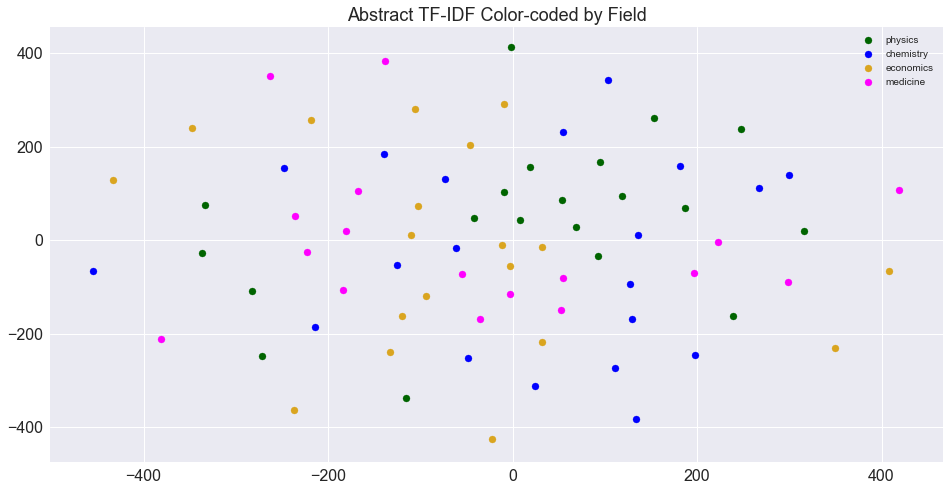

In [138]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
for areadf, colr, field in zip(areadflist,fourcolors,fieldset):
    ax.scatter(areadf.xcoord,areadf.ycoord,color=colr,label=field)
ax.legend()

pts = 18 #font pt size

plt.rc('axes', titlesize=pts, labelsize=pts)     # font size of the axes titles and labels
plt.rc('xtick', labelsize=pts-2)    # font size of the tick labels
plt.rc('ytick', labelsize=pts-2)    # font size of the tick labels
plt.rc('figure', titlesize=30) #title font size, slightly larger than the other text

plt.title('Abstract TF-IDF Color-coded by Field')
#plt.savefig("images/dots-by-field.png")
plt.show()

The most noticeable group is about 10 Physics publications near center, at about coordinate pair (50, 100).

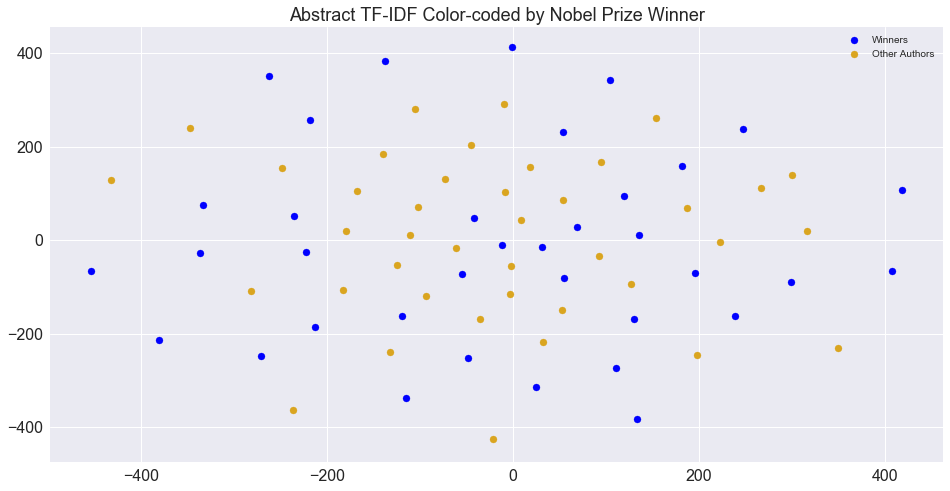

In [139]:
#see how coauthor column compares
winners = finaldf[finaldf["coauthor"]==0]
coauths = finaldf[finaldf["coauthor"]==1]

coautcatlist=[winners,coauths]
labellist = ["Winners","Other Authors"]

twocolors = ["blue","goldenrod"]

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
for df, colr, each in zip(coautcatlist,twocolors,labellist):
    ax.scatter(df.xcoord,df.ycoord,color=colr,label=each)
ax.legend()

pts = 18 #font pt size

plt.rc('axes', titlesize=pts, labelsize=pts)     # font size of the axes titles and labels
plt.rc('xtick', labelsize=pts-2)    # font size of the tick labels
plt.rc('ytick', labelsize=pts-2)    # font size of the tick labels
plt.rc('figure', titlesize=30) #title font size, slightly larger than the other text

plt.title('Abstract TF-IDF Color-coded by Nobel Prize Winner')
#plt.savefig("images/dots-by-winner.png")
plt.show()

There appears to be a few clusters, one in particular is made up of non-winners' publications text near the left center of the plot around coordinates (-100, 100).  In other graphs, the dots are different colors in this cluster, indicating that they are not by the same author, nor are they in the same field.

## Model
Using keras to determine a model of 7 clusters using TF-IDF values as X, predict for each y: `area` and `coauthor`.

In [144]:
#get dummies to create two targets: coauthor and field
ycoa = pd.get_dummies(finaldf["coauthor"]).values
yarea = pd.get_dummies(finaldf["area"]).values

In [145]:
tfidframe.shape

(76, 2500)

In [146]:
X = [row for row in tfidframe.values] #list of rows (numpy arrays)

In [147]:
X = np.array(X) #Sequential prefers numpy arrays to lists
type(X[0][0])

numpy.float64

### Model for `coauthor` as Target

In [148]:
#train test split
X_train, X_test, yc_train, yc_test = train_test_split(X, ycoa, test_size=0.33, random_state=321)

In [149]:
modelc = Sequential()
embedsize = 32 #there are 84 records
numwords = tfidframe.shape[1] #and 2500 tokens

In [150]:
modelc.add(Embedding(numwords, embedsize))
modelc.add(LSTM(10, return_sequences=True))
modelc.add(GlobalMaxPool1D())
modelc.add(Dropout(0.5))
modelc.add(Dense(20, activation='relu'))
modelc.add(Dropout(0.5))
modelc.add(Dense(2, activation='softmax')) #coauthor has two possibilities

In [151]:
modelc.compile(loss="categorical_crossentropy",optimizer="SGD",metrics=["accuracy"])

In [154]:
modelc.fit(X_train, yc_train,epochs=10,batch_size=15)

Epoch 1/10
4/4 [==============================] - 9s 2s/step - loss: 0.6983 - accuracy: 0.3800
Epoch 2/10
4/4 [==============================] - 9s 2s/step - loss: 0.6947 - accuracy: 0.4800
Epoch 3/10
4/4 [==============================] - 9s 2s/step - loss: 0.6926 - accuracy: 0.5400
Epoch 4/10
4/4 [==============================] - 9s 2s/step - loss: 0.6981 - accuracy: 0.4000
Epoch 5/10
4/4 [==============================] - 9s 2s/step - loss: 0.6917 - accuracy: 0.4400
Epoch 6/10
4/4 [==============================] - 9s 2s/step - loss: 0.6981 - accuracy: 0.3800
Epoch 7/10
4/4 [==============================] - 9s 2s/step - loss: 0.6926 - accuracy: 0.5800
Epoch 8/10
4/4 [==============================] - 9s 2s/step - loss: 0.6930 - accuracy: 0.5400
Epoch 9/10
4/4 [==============================] - 9s 2s/step - loss: 0.6925 - accuracy: 0.5000
Epoch 10/10
4/4 [==============================] - 9s 2s/step - loss: 0.6944 - accuracy: 0.5200


The loss seems large, at .7, but the accuracy improved over the epochs from .38 to .52.

In [124]:
yc_preds = modelc.predict(X_test) #I can compare with .evaluate more conveniently

In [155]:
traincresults = modelc.evaluate(X_train, yc_train)
testcresults = modelc.evaluate(X_test, yc_test)

1/1 [==============================] - 0s 0s/step - loss: 0.6919 - accuracy: 0.5769


The accuracy on the test set is about 57%.  The loss is lower than 1, but still rather high and improved minimally from the first epoch. 

### Model for `area` as the target

In [156]:
#train test split
X_train, X_test, ya_train, ya_test = train_test_split(X, yarea, test_size=0.33, random_state=321)

In [157]:
modela = Sequential()
embedsize = 32 #there are 84 records
numwords = tfidframe.shape[1] #and 2500 tokens

In [158]:
modela.add(Embedding(numwords, embedsize))
modela.add(LSTM(10, return_sequences=True))
modela.add(GlobalMaxPool1D())
modela.add(Dropout(0.5))
modela.add(Dense(20, activation='relu'))
modela.add(Dropout(0.5))
modela.add(Dense(4, activation='softmax')) #area has 4 possibilities

In [159]:
modela.compile(loss="categorical_crossentropy",optimizer="SGD",metrics=["accuracy"])

In [160]:
modela.fit(X_train, ya_train,epochs=10,batch_size=15)

Epoch 1/10
4/4 [==============================] - 9s 2s/step - loss: 1.3882 - accuracy: 0.2400
Epoch 2/10
4/4 [==============================] - 9s 2s/step - loss: 1.3825 - accuracy: 0.3200
Epoch 3/10
4/4 [==============================] - 9s 2s/step - loss: 1.3885 - accuracy: 0.2000
Epoch 4/10
4/4 [==============================] - 9s 2s/step - loss: 1.3874 - accuracy: 0.3400
Epoch 5/10
4/4 [==============================] - 9s 2s/step - loss: 1.3826 - accuracy: 0.3200
Epoch 6/10
4/4 [==============================] - 9s 2s/step - loss: 1.3829 - accuracy: 0.3400
Epoch 7/10
4/4 [==============================] - 9s 2s/step - loss: 1.3876 - accuracy: 0.2600
Epoch 8/10
4/4 [==============================] - 9s 2s/step - loss: 1.3915 - accuracy: 0.1800
Epoch 9/10
4/4 [==============================] - 9s 2s/step - loss: 1.3838 - accuracy: 0.3200
Epoch 10/10
4/4 [==============================] - 9s 2s/step - loss: 1.3837 - accuracy: 0.2600


The accuracy improved a little over the epochs, but perhaps it needs more of them to converge.

In [131]:
ya_preds = modela.predict(X_test)

In [161]:
trainaresults = modela.evaluate(X_train, ya_train)
testaresults = modela.evaluate(X_test, ya_test)

1/1 [==============================] - 0s 0s/step - loss: 1.3945 - accuracy: 0.1923


The accuracy is 19% for the test data and 30% for the training data, both with loss values near 1.4.

### T-test for significance for `coauthor` feature

I'd like to see whether there is a significant difference between TF-IDF values for abstract text by a Nobel winner (0) or a coauthor (1).  As a hypothesis test:

$H_0$ : The mean difference between the TF-IDF values for non-coauthors and coauthors is zero. Rephrased, $\mu_{nobel} = \mu_{coauthor}$

$H_1$ : The mean difference between the TF-IDF values for non-coauthors and coauthors is nonzero. Rephrased, $\mu_{nobel} \ne \mu_{coauthor}$

To prove the alternative hypothesis, I can use a two-tailed less-than test.

With the $p$ and $t$ values from a two-tailed test (returned by `ttest_ind`), I can reject the null hypothesis when $p < \alpha$ ($p$ being significant for an $\alpha$ of 0.05) and $t > 0$.

In [162]:
finaldf["tfidf_avg"] = [np.mean(i) for i in tfidframe.values] #average each row

In [163]:
#create lists of average TF-IDF values for whether coauthor/Nobel winner
coauth1tfidf = [tival for tival in finaldf[finaldf["coauthor"]==1].tfidf_avg]
coauth0tfidf = [tival for tival in finaldf[finaldf["coauthor"]==0].tfidf_avg]

In [164]:
ttestresults = stats.ttest_ind(coauth1tfidf,coauth0tfidf)

In [165]:
ttestresults

Ttest_indResult(statistic=-0.6905254298094251, pvalue=0.492024080650696)

That appears to not be significant; a publication authored by a Nobel prize-winner and that which was authored by a collaborator do not have abstracts that are significantly different.

### T-test for significance for `area` feature

I'd like to see whether there is a significant difference between TF-IDF values for abstract text by one field or another.  To prove the alternative hypothesis, these would be two-tailed, paired tests comparing the four possibilities for `area` (each pair would be field A compared to field B).

$H_0$ : The mean difference between the TF-IDF values for field A and field B is zero. Rephrased, $\mu_{A} = \mu_{B}$

$H_1$ : The mean difference between the TF-IDF values for field A and field B is nonzero. Rephrased, $\mu_{A} \ne \mu_{B}$

With the $p$ and $t$ values from a two-tailed test (returned by `ttest_ind`), I can reject the null hypothesis when $p < \alpha$ ($p$ being significant for an $\alpha$ of 0.05) and $t > 0$.

In [167]:
phystfidf = [tival for tival in finaldf[finaldf["area"]=="physics"].tfidf_avg]
chemtfidf = [tival for tival in finaldf[finaldf["area"]=="chemistry"].tfidf_avg]
econtfidf = [tival for tival in finaldf[finaldf["area"]=="economics"].tfidf_avg]
meditfidf = [tival for tival in finaldf[finaldf["area"]=="medicine"].tfidf_avg]

In [168]:
#pairwise Tukey test:
#information needs to be in numpy arrays
area_arrays = np.concatenate([np.array(phystfidf),np.array(chemtfidf),np.array(econtfidf),np.array(meditfidf)])
#and labels are important for it to handle the data properly
areanames = ["physics"]*len(phystfidf) + ["chemistry"]*len(chemtfidf) + ["economics"]*len(econtfidf) + ["medicine"]*len(meditfidf)

In [170]:
#get tukeyhsd test results with 0.05 for significant p-value
print(pairwise_tukeyhsd(area_arrays,areanames,0.05))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower  upper  reject
--------------------------------------------------
chemistry economics   0.0      -0.0  0.0001 False 
chemistry  medicine   0.0      -0.0  0.0001 False 
chemistry  physics  -0.0001  -0.0001  -0.0   True 
economics  medicine   0.0    -0.0001 0.0001 False 
economics  physics  -0.0001  -0.0002  -0.0   True 
 medicine  physics  -0.0001  -0.0002  -0.0   True 
--------------------------------------------------


By field, three combinations' null hypotheses can be rejected: chemistry-economics, chemistry-medicine, and economics-medicine.  Conversely, it means pairs with physics are not significantly different.  However, all values for `meandiff`, `lower` and `upper` are very close to 0.

## Interpret
Ultimately, the results rely on too little data. The model has a relatively high loss values and accuracy metrics that barely improve over the last few epochs of the Sequential Model from `keras`.  The t-test comparing TF-IDF values for co-authors and those for Nobel Prize winners did not find significance.  Pairwise tests comparing four different fields (`area`) found significance for half of the pairs (those combinations of chemistry, medicine and economics).

Comparing the TF-IDF for abstract text gives closeness based on the words' importances to the abstract.  With many abstracts containing specialized jargon from different disciplines, it was surprising that when graphing the values, the abstracts were not more clustered by `area`.

### Comparison to `sklearn`'s `TfidfTransformer` with `CountVectorizer`
Using the tokenized abstracts and a `set` of the words from all the abstracts, get TF-IDF values from `sklearn` methods.

In [208]:
#take tokenslists and put each list into one String, each word separated by spaces
corpus = []
vocab = [] #vocab will be set of all words from all tokens
for tokenlist in tokenslists:
    tokenstring=""
    lasttoken = tokenlist[-1]
    for token in tokenlist[:-1]:
        vocab.append(token)
        tokenstring+=token
        tokenstring+=" " #last token does not need space after it
    tokenstring+=lasttoken #each separated by spaces
    vocab.append(lasttoken)
    corpus.append(tokenstring)
len(corpus)

76

In [209]:
vocabul = set(vocab)
len(vocabul)

2500

In [184]:
tokenslists[10][-1]

'context'

In [185]:
corpus[10]

'present sufficient condition monotone matching environment utility fully transferable partner condition involve complementarity type total payoff match transferable utility case also monotonicity type degree transferability partner apply condition study model risk sharing incentive problem deriving new result predicted matching pattern context'

In [210]:
#without a pipeline
vectorizer = CountVectorizer()
vectorized = vectorizer.fit_transform(corpus)

In [242]:
vectorized[10]

<1x2474 sparse matrix of type '<class 'numpy.int64'>'
	with 34 stored elements in Compressed Sparse Row format>

In [213]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(vectorized)

In [244]:
tfidf

<76x2474 sparse matrix of type '<class 'numpy.float64'>'
	with 4248 stored elements in Compressed Sparse Row format>

In [247]:
vectarr = vectorized.toarray()
tfidfarr = tfidf.toarray()

In [252]:
vectdf = pd.DataFrame(vectarr, columns=vectorizer.get_feature_names())
vectdf.head()

,00001,005,012,019,04,05,075,0982,10,100,...,young,youth,zero,zerodispersion,zettawatt,zone,zt,µm,αhelices,μm
0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [253]:
tfidfdf = pd.DataFrame(tfidfarr, columns=vectorizer.get_feature_names())
tfidfdf.head()

,00001,005,012,019,04,05,075,0982,10,100,...,young,youth,zero,zerodispersion,zettawatt,zone,zt,µm,αhelices,μm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.224790,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076108,0.0,...,0.0,0.0,0.0,0.0,0.104169,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125844,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


These TF-IDF values used different tokens, removing any shorter than two characters.